# Домашнее задание

В этом домашнем задании предлагаем вам попрактиковаться в прогнозировании стоимости биткоина при помощи линейной регрессии.

In [78]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/BTC_5min_sample.csv",
                   parse_dates=True,
                   index_col='timestamp')

data.head()

,open,high,low,close,volume
timestamp,,,,,
2023-06-18 00:00:00,26519.10,26542.5,26501.76,26515.80,35.4498
2023-06-18 00:05:00,26508.01,26535.0,26506.13,26511.30,7.4262
2023-06-18 00:10:00,26511.30,26551.0,26508.77,26519.62,18.9461
2023-06-18 00:15:00,26519.44,26550.0,26464.43,26511.99,89.2364
2023-06-18 00:20:00,26513.33,26541.0,26414.28,26439.52,90.0204


Будем прогнозировать стоимость биткоина на момент открытия торгов (`open`).

<Axes: xlabel='timestamp'>

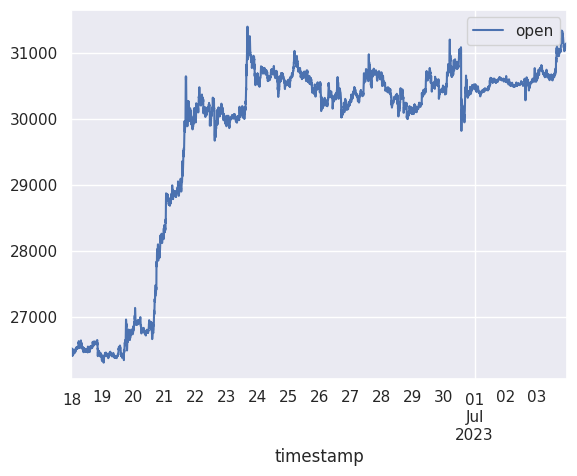

In [79]:
import seaborn as sns
sns.set(style='darkgrid', palette='deep')
data = data[['open']]
data.plot()

<Axes: xlabel='timestamp'>

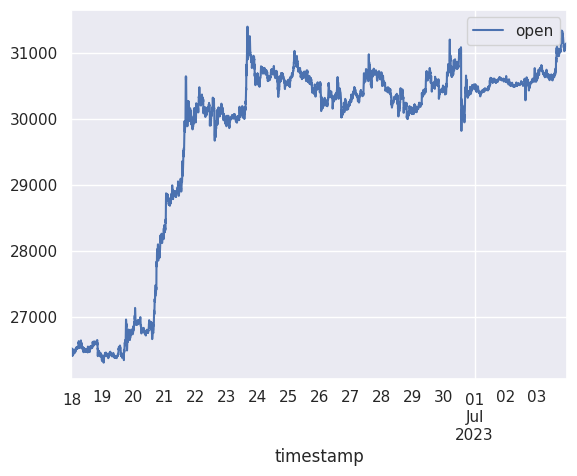

In [80]:
data = data[['open']]
data.plot()

Проделайте следующие шаги:

* Разбейте данные на тренировочную и тестовую часть. В тест отправьте 15% данных

* Извлеките лаговые признаки

* Извлеките агрегированные признаки (средняя стоимость за день, час)

Рекомендуется использовать функцию preprocess_data с вебинара (однако, надо будет незначительно ее поменять, исходя из данных задачи).

Задайте гиперпараметры по умолчанию (в функции preprocess_data, если будете использовать ее):
* `lag_start`=5
* `lag_end`=20
* `test_size`=0.15

<Axes: xlabel='timestamp'>

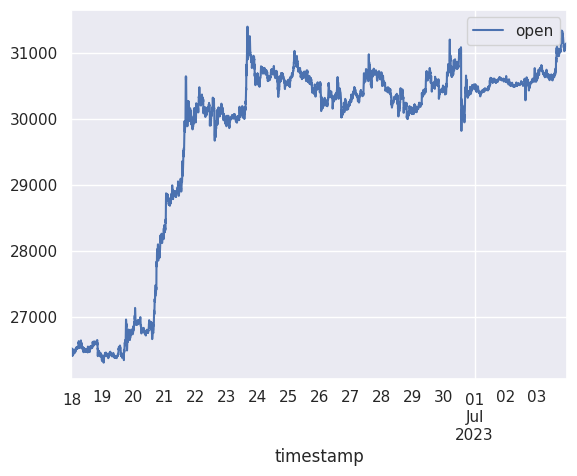

In [81]:
data = data.sort_index()
data.plot()

In [82]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [83]:
from datetime import datetime

def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    # your code here
    data = pd.DataFrame(data.copy())
    # найдем границу времени для train test split
    time_threshold = data.iloc[int(len(data) * (1 - test_size)):(int(len(data) * (1 - test_size)) + 1)].index.format()[0]

    # добавляем лаговые признаки
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['open'].shift(i)
    data = data.dropna()

    # считаем среднее цены открытия за час (только по тренировочной части)
    data["hour"] = data.index.hour
    data["hour_average"] = list(map(code_mean(data.loc[:time_threshold], "hour", "open").get, data.hour))
    data.drop(["hour"], axis=1, inplace=True)

    # считаем среднее цены открытия за день (только по тренировочной части)
    data["day"] = data.index.hour
    data["day_average"] = list(map(code_mean(data.loc[:time_threshold], "day", "open").get, data.day))
    data.drop(["day"], axis=1, inplace=True)

    # разбиваем весь датасет на train+test
    X_train = data.loc[:time_threshold].drop(["open"], axis=1)
    y_train = data.loc[:time_threshold]["open"]
    X_test = data.loc[time_threshold:].drop(["open"], axis=1)
    y_test = data.loc[time_threshold:]["open"]

    return X_train, X_test, y_train, y_test

Обучите линейную регрессию с гиперпараметрами по умолчанию на тренировочных данных и вычислите ошибку MAE на тестовых данных.

Чему она получилась равна? (Ответ округлите до целого числа).

Также нарисуйте график правильного ответа и прогноза на тесте.

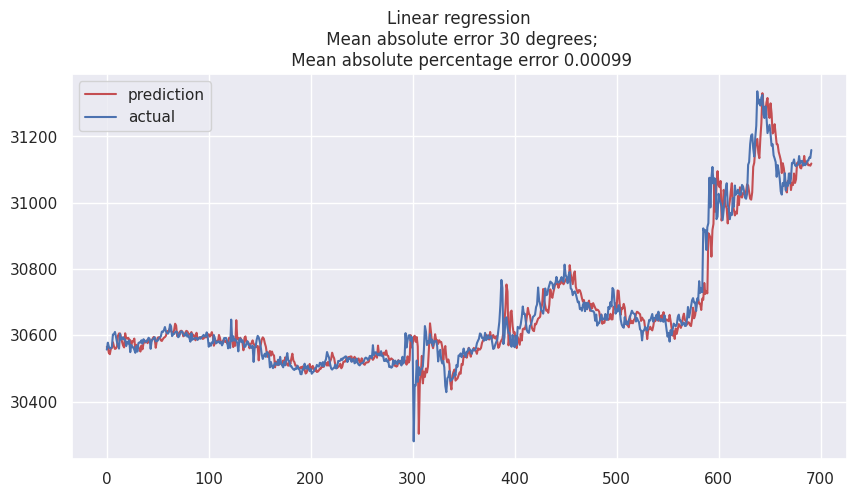

In [84]:
# your code here
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

X_train, X_test, y_train, y_test = preprocess_data(data)
X_train.shape, X_test.shape

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
prediction = linear_regression.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {round(mean_absolute_error(prediction, y_test))} degrees;\n Mean absolute percentage error {round(mean_absolute_percentage_error(prediction, y_test), 5)}");

Попробуйте подобрать гиперпараметры `lag_start`, `lag_end`, а также придумать новые полезные агрегрированные признаки для улучшения качества прогноза.

Пропорции разбиения (в тесте 15% данных) не трогайте. Ошибку MAE все так же считайте на тесте.

**Решение:**
Попробуем изменить значения lag_start, lag_end; а также добавим признаки с медианой цены на момент открытия за час и за день; добавим признак, обозначающий день недели

In [85]:
def code_median(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].median())

In [88]:
def preprocess_data(data, lag_start=1, lag_end=15, test_size=0.15):

    # your code here
    data = pd.DataFrame(data.copy())
    # найдем границу времени для train test split
    time_threshold = data.iloc[int(len(data) * (1 - test_size)):(int(len(data) * (1 - test_size)) + 1)].index.format()[0]

    # добавляем лаговые признаки
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['open'].shift(i)
    data = data.dropna()

    # считаем среднее и медиану цены открытия за час (только по тренировочной части)
    data["hour"] = data.index.hour
    data["hour_average"] = list(map(code_mean(data.loc[:time_threshold], "hour", "open").get, data.hour))
    data["hour_median"] = list(map(code_median(data.loc[:time_threshold], "hour", "open").get, data.hour))
    data.drop(["hour"], axis=1, inplace=True)

    # считаем среднее и медиану цены открытия за день (только по тренировочной части)
    data["day"] = data.index.hour
    data["day_average"] = list(map(code_mean(data.loc[:time_threshold], "day", "open").get, data.day))
    data["day_median"] = list(map(code_median(data.loc[:time_threshold], "day", "open").get, data.day))
    data.drop(["day"], axis=1, inplace=True)

    # добавляем признак с днем недели
    data["is_weekend"] = data.index.strftime('%w')

    # разбиваем весь датасет на train+test
    X_train = data.loc[:time_threshold].drop(["open"], axis=1)
    y_train = data.loc[:time_threshold]["open"]
    X_test = data.loc[time_threshold:].drop(["open"], axis=1)
    y_test = data.loc[time_threshold:]["open"]

    return X_train, X_test, y_train, y_test

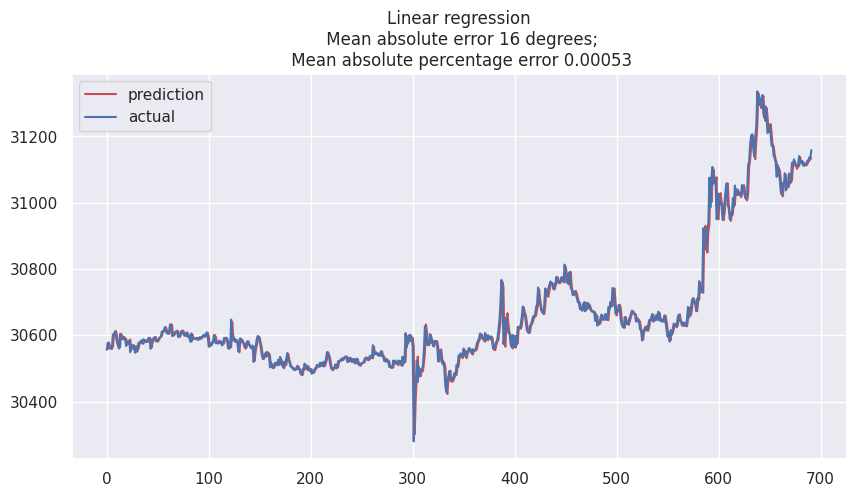

In [89]:
X_train, X_test, y_train, y_test = preprocess_data(data)
X_train.shape, X_test.shape

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
prediction = linear_regression.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {round(mean_absolute_error(prediction, y_test))} degrees;\n Mean absolute percentage error {round(mean_absolute_percentage_error(prediction, y_test), 5)}");

Ура, ошибка уменьшилась! Правда, теперь прогноз настолько близок к верным данным, что кажется, как будто бы модель могла переобучиться :(